# Setup the imports

In [1]:
import pandas as pd
import os
from datetime import datetime, timezone
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
import fileinput
import shutil

all_data = pd.DataFrame()


## Setup the CSV files

In [2]:
path = os.getcwd()
files = os.listdir(path)
os.makedirs(path + './.temp/', exist_ok=True)
tempDir = path + '/.temp/'
files_xls = [f for f in files if f[-3:] == 'xls']

counter = 0
for file in files_xls: 
    with open(file) as fin, open('./.temp/' + str(counter) + '_New_File.txt', 'w') as fout:
        for line in fin.readlines()[1:]: # don't look at the first line
            fout.write(line.replace('\t', ','))
        counter += 1

## Write the CSVs

In [3]:
tempDir = path + '/.temp/'
tempFiles = os.listdir(tempDir)

files_txt = [f for f in tempFiles if f[-3:] == 'txt']

counter = 0
for file in files_txt: 
    with open(tempDir + file) as fin, open('./.temp/' + str(counter) + '_final.csv', 'w') as fout:
        for line in fin:
            fout.write(line.replace('BERTH_9_FEEDBACK,BERTH_10_FEEDBACK,', 'BERTH_9_FEEDBACK,BERTH_10_FEEDBACK,NothinToSeeHere,'))
        counter += 1

### Append all of the CSVs to one data frame

In [4]:
tempFiles = os.listdir(tempDir)
files_csv = [f for f in tempFiles if f[-3:] == 'csv']

for file in files_csv:
    #print(tempDir + file)
    data = pd.read_csv(tempDir + file)
    all_data = all_data.append(data)

In [5]:
all_data.head()

,Time date,Ticks,Car type,SystemMode,RegulationMode,DI_400_VAC,DI_AIR_FLOW,DI_SPARE_1,DI_CAR_TYPE_0,DI_CAR_TYPE_1,...,BERTH_3_5_FEEDBACK,BERTH_4_FEEDBACK,BERTH_5_2_FEEDBACK,BERTH_6_3_FEEDBACK,BERTH_7_6_FEEDBACK,BERTH_8_FEEDBACK,BERTH_9_FEEDBACK,BERTH_10_FEEDBACK,YoYoMa,Unnamed: 305
0,2020-11-26 03:43:18,34199910,CLUB,MODE_STANDBY,MODE_NOT_IN_REGULATION,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2020-11-26 03:48:19,34499910,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
2,2020-11-26 03:53:19,34799910,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
3,2020-11-26 03:55:34,34933825,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
4,2020-11-26 03:55:37,34937115,CLUB,MODE_STANDBY,MODE_NOT_IN_REGULATION,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN


### Write all of the CSV files to one file

In [5]:
all_data.to_csv("all_data.csv", index=False)
#shutil.rmtree(tempDir)

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2461 entries, 0 to 257
Columns: 306 entries, Time date to Unnamed: 305
dtypes: float64(79), int64(223), object(4)
memory usage: 5.8+ MB


# Import consolidated data into a df

In [6]:
df = pd.read_csv('all_data.csv')

#### Sort by date and remove 2006 data

In [7]:
df['Time date'] = pd.to_datetime(df['Time date'])
df = df.sort_values(by='Time date')
df = df.reset_index(drop=True) # Reset the index to line up with the sorted data.
df = df[(df['Time date'].dt.year > 2006)]

### Filter out the temperature data for the temperature sensors

In [8]:
temperatureData = pd.DataFrame()

temperatureData['Time date'] = df['Time date']
temperatureData['External Grill Supply'] = df['TEMPERATURE_SUPPLY_1']
temperatureData['SAT1'] = df['TEMPERATURE_SUPPLY_2']
temperatureData['SAT2'] = df['TEMPERATURE_RETURN']
temperatureData['Vestibule E2'] = df['TEMP. VESTIBULE_LEFT']
temperatureData['Vestibule E1'] = df['TEMP. STAFF_WC']
temperatureData['Dining Floor Return'] = df['TEMPERATURE_GUARD_GALLEY_WC']
temperatureData['Guards Rest Room'] = df['TEMP. GUARD_GALLEY_WC']
temperatureData['Guards Control Room'] = df['TEMP. BERTH_1']

temperatureData.to_csv("temperatureData.csv", index=False)

### Filter out the damper data 

In [9]:
dmaperData = pd.DataFrame()
dmaperData['Time date'] = df['Time date']
dmaperData['Fresh Air Damper'] = df['FRESH_DAMPER_FEEDBACK']
dmaperData['Return Air Damper'] = df['RETURN_DAMPER_FEEDBACK']

dmaperData.to_csv("dmaperData.csv", index=False)

# Plot the data

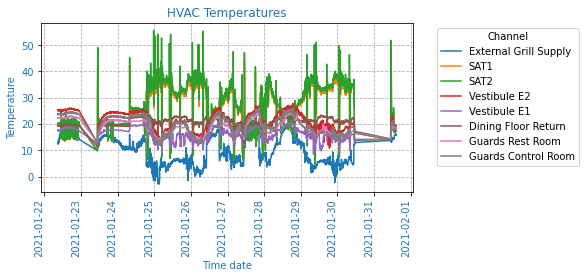

In [10]:
dfTemp = temperatureData[(temperatureData['Time date'].dt.year > 2006)].copy().set_index('Time date')
dfTemp.plot(kind='line', legend=None)
plt.xticks(color='C0', rotation='vertical')
plt.xlabel('Time date', color='C0', size=10)
plt.yticks(color='C0')
plt.tight_layout(pad=2)
plt.title('HVAC Temperatures', color='C0')
plt.ylabel('Temperature', color='C0', size=10)
plt.grid('on', linestyle='--')
lgd = plt.legend(title='Channel', bbox_to_anchor=(1.05, 1))

plt.savefig('myfig100.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', format=None, bbox_extra_artists=(lgd,), bbox_inches='tight',
        transparent=False, pad_inches=0.1)
plt.show()

# Setup the damper data

In [11]:
df = pd.read_csv('all_data.csv')
df['Time date'] = pd.to_datetime(df['Time date'])
df = df.sort_values(by='Time date')
df = df[(df['Time date'].dt.year > 2006)]


damperData = pd.DataFrame()

damperData['Time date'] = df['Time date']
damperData['Fresh Air Damper'] = df['FRESH_DAMPER_FEEDBACK']
damperData['Return Air Damper'] = df['RETURN_DAMPER_FEEDBACK']

## Overlay the Damper values on the Y2 axis

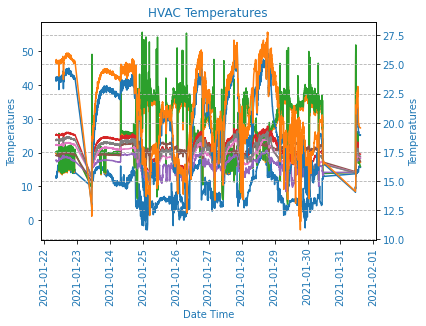

In [20]:
dfTemp = temperatureData.set_index('Time date')
damper = dmaperData.set_index('Time date')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Date Time', color='C0')
ax1.set_ylabel('Temperatures', color='C0')
ax2.set_ylabel('Temperatures', color='C0')
ax1.tick_params(axis='x', labelcolor='C0', labelrotation=90)
ax1.tick_params(axis='y', labelcolor='C0')
ax2.tick_params(axis='y', labelcolor='C0')

curve1 = ax1.plot(dfTemp, label='Temperature supply')
curve2 = ax2.plot(damper, label='Damper')

#lgd = plt.legend(title='Sensor', bbox_to_anchor=(1.4, 1))
     
#lgd1 = curve1.legend(title='Sensor', bbox_to_anchor=(1.4, 1))
#lgd2 = curve2.legend(title='Sensor', bbox_to_anchor=(1.4, 2))

plt.title('HVAC Temperatures', color='C0')
plt.grid('on', linestyle='--')

plt.savefig('myfig100.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', format=None, bbox_inches='tight',
        transparent=False, pad_inches=0.1)

plt.show()

In [10]:
temperatureData = pd.read_csv("temperatureData.csv")
temperatureData = temperatureData.set_index('Time date')
dmaperData = pd.read_csv("dmaperData.csv")
dmaperData = dmaperData.set_index('Time date')

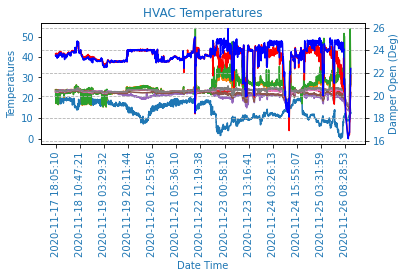

Seconds: 40.968064069747925


In [13]:

y1 = temperatureData['External Grill Supply']
#y2 = temperatureData['SAT1']
#y3 = temperatureData['SAT2']
#y4 = temperatureData['Vestibule E2']
#y5 = temperatureData['Vestibule E1']
#y6 = temperatureData['Dining Floor Return']
#y7 = temperatureData['Guards Rest Room']
#y8 = temperatureData['Guards Control Room']
#y9 = temperatureData['Return Air Damper']
#y0 = temperatureData['Fresh Air Damper']

x = temperatureData.index


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.set_xlabel('Date Time', color='C0')
ax1.set_ylabel('Temperatures', color='C0')
ax1.tick_params(axis='x', labelcolor='C0', labelrotation=90)
ax1.tick_params(axis='y', labelcolor='C0')

curve1 = ax1.plot(x, y1, label='Temperature supply', color='tab:blue')
curve2 = ax1.plot(y2, label='SAT1', color='tab:orange')
curve3 = ax1.plot(y3, label='SAT2', color='tab:green')
curve4 = ax1.plot(y4, label='Vestibule E2', color='tab:red')
curve5 = ax1.plot(y5, label='Vestibule E1', color='tab:purple')
curve6 = ax1.plot(y6, label='Dining Floor Return', color='tab:brown')
curve7 = ax1.plot(y7, label='Guards Rest Room', color='tab:pink')
curve8 = ax1.plot(y8, label='Guards Control Room', color='tab:gray')

ax2.set_ylabel('Damper Open (Deg)', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
curve9 = ax2.plot(y9, label='Return Air Damper', color='r')
curve0 = ax2.plot(y0, label='Fresh Air Damper', color='b')

plt.tight_layout(pad=2)
plt.title('HVAC Temperatures', color='C0')
#lgd = plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid('on', linestyle='--')

plt.plot()

ax1.set_xticks(range(0,len(x), 200)) 
plt.show()
print("Seconds: " + str(time.time() - start))

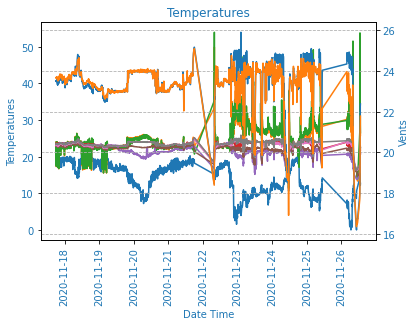

In [37]:
dfTemp = temperatureData.set_index('Time date')
vents = dmaperData.set_index('Time date')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Date Time', color='C0')
ax1.set_ylabel('Temperatures', color='C0')
ax2.set_ylabel('Vents', color='C0')
ax1.tick_params(axis='x', labelcolor='C0', labelrotation=90)
ax1.tick_params(axis='y', labelcolor='C0')
ax2.tick_params(axis='y', labelcolor='C0')

curve1 = ax1.plot(dfTemp, label='Temperature supply')
curve2 = ax2.plot(vents, label='Vents')

plt.title('Temperatures', color='C0')
plt.grid('on', linestyle='--')

plt.show()

## Setup the logger data

In [25]:
tempLogs = pd.DataFrame()
df = pd.DataFrame()
path = os.getcwd()
files = os.listdir(path)
tempDir = './.tempDL/'
os.makedirs(tempDir, exist_ok=True)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
counter = 0
for file in files_xlsx:
    shutil.copy(file, tempDir + str(counter) + '_New_File.xlsx')
    data = pd.read_excel(tempDir + str(counter) + '_New_File.xlsx', engine='openpyxl')
    tempLogs = tempLogs.append(data)
    counter += 1
df['Time date'] = tempLogs['Time']
df['Temperature °C'] = tempLogs['Celsius(°C)']
df['Time date'] = pd.to_datetime(df['Time date'])
df = df.sort_values(by='Time date')
df = df.reset_index(drop=True)
df.to_csv('loggerData.csv')
shutil.rmtree(tempDir)

loggerData = pd.read_csv("loggerData.csv")
loggerData = loggerData.set_index('Time date')

loggerData = loggerData.dropna(how='any')

start = loggerData.index[0]
finish = loggerData.index[-1]


### Overlay the logger with the hvac

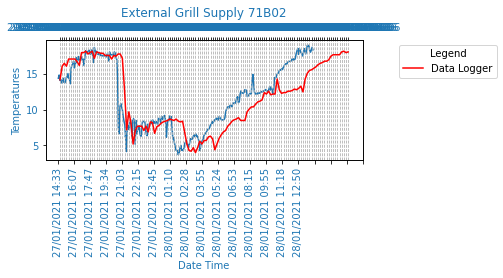

In [32]:
df = pd.read_csv("test.csv")
temperatureData = df.set_index('Time date')
#temperatureData = df[(df['Time date'] >= loggerData.index[0]) & (df['Time date'] <= loggerData.index[-1])].copy().set_index('Time date')

loggerData = loggerData.iloc[1:] # Drop rows

dl = loggerData['Temperature °C']

y1 = temperatureData['External Grill Supply']
#y2 = temperatureData['SAT1']
#y3 = temperatureData['SAT2']
#y4 = temperatureData['Vestibule E2']
#y5 = temperatureData['Vestibule E1']
#y6 = temperatureData['Dining Floor Return']
#y7 = temperatureData['Guards Rest Room']
#y8 = temperatureData['Guards Control Room']
#y9 = temperatureData['Return Air Damper']
#y0 = temperatureData['Fresh Air Damper']

x = temperatureData.index


fig, ax1 = plt.subplots()
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

ax1.set_xlabel('Date Time', color='C0')
ax1.set_ylabel('Temperatures', color='C0')
ax1.tick_params(axis='x', labelcolor='C0', labelrotation=90)
ax1.tick_params(axis='y', labelcolor='C0')
ax2.tick_params(axis='x', labelcolor='C0')

curve1 = ax1.plot(x, y1, label='External Grill Supply 71B02', color='tab:blue')
#curve2 = ax1.plot(y2, label='SAT1 MERAK', color='tab:orange')
#curve3 = ax1.plot(y3, label='SAT2 MERAK', color='tab:green')
#curve4 = ax1.plot(y4, label='Vestibule E2 71B04', color='tab:red')
#curve5 = ax1.plot(y5, label='Vestibule E1 71B03', color='tab:purple')
#curve6 = ax1.plot(y6, label='Dining Floor Return 71B01', color='tab:brown')
#curve7 = ax1.plot(y7, label='Guards Rest Room 71B05', color='tab:pink')
#curve8 = ax1.plot(y8, label='Guards Control Room 71B06', color='tab:gray')

ax2.tick_params(axis='y', labelcolor='C0')

curveDL = ax2.plot(dl, label='Data Logger', color='r')

plt.tight_layout(pad=2)
plt.title('External Grill Supply 71B02', color='C0')
lgd = plt.legend(title='Legend', bbox_to_anchor=(1.1, 1), loc='upper left')
plt.grid('on', linestyle='--')

# plt.plot()

ax1.set_xticks(range(0,len(x), 100)) 
#ax2.set_xticks([]) # Hide the xticks on the top axis.

plt.savefig('myfig100.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', format=None, bbox_extra_artists=(lgd,), bbox_inches='tight',
        transparent=False, pad_inches=0.1)

plt.show()

In [18]:
temperatureData.head()

,External Grill Supply,SAT1,SAT2,Vestibule E2,Vestibule E1,Dining Floor Return,Guards Rest Room,Guards Control Room
Time date,,,,,,,,


In [18]:
df = pd.read_csv("temperatureData.csv")
temperatureData = df[(df['Time date'] >= loggerData.index[0]) & (df['Time date'] <= loggerData.index[-1])].copy().set_index('Time date')

In [19]:
print(temperatureData.index[0])
print(temperatureData.index[-1])

2021-01-27 14:28:05
2021-01-28 13:54:37


In [20]:
print(loggerData.index[0])
print(loggerData.index[-1])

2021-01-27 14:24:47
2021-01-28 13:54:47
